In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForMaskedLM,AutoModelForCausalLM, AutoModel, AutoModelForQuestionAnswering
from IPython.display import clear_output
from pathlib import Path
from tqdm.notebook import tqdm

device = torch.device('mps')
print(f'processing device is set to : {device}')

processing device is set to : mps


## 코사인 유사도 도출
----

모델 로드

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForQuestionAnswering, AutoModelForCausalLM

model_name = 'biobert-pubmed'

def model_select(model_name):
    models = {
        #팜버트
        'PharmBERT-filtered': ("Lianglab/PharmBERT-uncased", AutoModelForMaskedLM),
        'PharmBERT-unfiltered': ("Lianglab/PharmBERT-uncased", AutoModelForMaskedLM),
        'PharmBERT-FT1': ("./fine-tuning/PharmBERT fine-tuning/PharmBERT_FT1", AutoModelForMaskedLM),
        'PharmBERT-cased': ("Lianglab/PharmBERT-cased", AutoModelForMaskedLM),
        
        #바이오버트
        'biobert_v1.1': ("dmis-lab/biobert-v1.1", AutoModel),
        'biobert_v1.2': ("dmis-lab/biobert-base-cased-v1.2", AutoModelForMaskedLM),
        'biobert-large-cased-squad': ("dmis-lab/biobert-large-cased-v1.1-squad", AutoModelForQuestionAnswering),
        'biobert-large-cased': ("dmis-lab/biobert-large-cased-v1.1", AutoModelForQuestionAnswering),
        'biobert-pubmed': ("clagator/biobert_v1.1_pubmed_nli_sts", AutoModel),
        
        #바이오메드gpt
        'BioMedGPT': ("PharMolix/BioMedGPT-LM-7B", AutoModelForCausalLM),
        
        # BiomedNLP-PubMedBERT 추가
        'BiomedBERT': ("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext", AutoModelForMaskedLM),
        
        # bert-base-uncased
        'bert-base-uncased': ("bert-base-uncased", AutoModel),
    }

    # 모델 이름에 따라 모델 경로와 모델 클래스를 조회합니다.
    model_path, model_class = models.get(model_name, (model_name, AutoModel))

    # 토크나이저와 모델을 로드합니다.
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = model_class.from_pretrained(model_path, output_hidden_states=True).to(device)

    print(f"model name: {model_path}")

    return model, tokenizer

model, tokenizer = model_select(model_name)


model name: clagator/biobert_v1.1_pubmed_nli_sts


In [3]:
total_params = sum(p.numel() for p in model.parameters())
print(f"총 파라미터 개수: {total_params}")

model_save_dir = f'./model output/{model_name}/'
model_save_path = Path(model_save_dir)

총 파라미터 개수: 108310272


인접행렬 로드

In [4]:
drug_matrix_name = f'drug-drug similarity matrix.csv'
se_matrix_name = f'se-se similarity matrix.csv'

df = pd.read_csv('./drug-SE adjacency matrix.csv', index_col=0)
df

,abdominal cramps,abdominal pain,gastrointestinal pain,amblyopia,anaemia,anorexia,decreased appetite,anxiety,arrhythmia,asthenia,...,diabetic foot infection,ventilator associated pneumonia,pain neck/shoulder,corneal dystrophy,vitreous prolapse,pupillary reflex impaired,pupillary deformity,retinal scar,meniere's disease aggravated,arcus juvenilis
carnitine,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
gamma-aminobutyric,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5-aminolevulinic,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
leucovorin,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5-methyltetrahydrofolate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lymecycline,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-3 pufas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pegfilgrastim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colestyramine,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [5]:
def get_drug_embedding(drug_name):
    new_drug_name = drug_name
    new_tokens = tokenizer.tokenize(new_drug_name)
    new_tokens = ['[CLS]'] + new_tokens + ['[SEP]']
    
    new_input_ids = tokenizer.convert_tokens_to_ids(new_tokens)
    new_input_ids = torch.tensor([new_input_ids])
    
    new_input_ids = new_input_ids.to(device)

    #AvgPooling 
    with torch.no_grad(): # 이 블록 내에서의 연산은 그래디언트 계산이 필요 없음   
        new_outputs = model(new_input_ids)
        new_embedding = new_outputs.hidden_states[-1].squeeze(0)
        new_embedding = new_embedding.mean(dim=0)

    #MaxPooling
    # with torch.no_grad(): # 이 블록 내에서의 연산은 그래디언트 계산이 필요 없음
    #     new_outputs = model(new_input_ids)
    #     new_embedding = new_outputs.hidden_states[-1].squeeze(0)
    #     new_embedding, _ = torch.max(new_embedding, dim=0) # Max Pooling
    
    
    return new_embedding    

def compute_cosine_similarity_matrix(embeddings):
    embeddings_tensor = torch.stack(embeddings)

    cosine_sim_matrix = torch.mm(embeddings_tensor, embeddings_tensor.T) 
    cosine_sim_matrix /= embeddings_tensor.norm(dim=1).unsqueeze(1)
    cosine_sim_matrix /= embeddings_tensor.norm(dim=1).unsqueeze(0)

    return cosine_sim_matrix

drug_names = df.index.tolist()
side_effect_names = df.columns.tolist()

약물 코사인 유사도 구하기

In [6]:
drug_embeddings = [get_drug_embedding(drug_name) for drug_name in drug_names]

drug_cosine_similarity_matrix = compute_cosine_similarity_matrix(drug_embeddings)

drug_cosine_similarity_df = pd.DataFrame(drug_cosine_similarity_matrix.detach().cpu().numpy(), 
                                         index=drug_names, 
                                         columns=drug_names)

if not model_save_path.exists():
        # 디렉토리 생성
        model_save_path.mkdir()
        drug_cosine_similarity_df.to_csv(f'{model_save_dir}{drug_matrix_name}')
else:
    drug_cosine_similarity_df.to_csv(f'{model_save_dir}{drug_matrix_name}')


# drug_cosine_similarity_df.to_csv(drug_matrix_name)

drug_cosine_similarity_df

,carnitine,gamma-aminobutyric,5-aminolevulinic,leucovorin,5-methyltetrahydrofolate,pge2,prostacyclin,prostaglandin,acetate,acetylcholine,...,demeclocycline,heparin,hydroxypropyl,a77,tigecycline,lymecycline,n-3 pufas,pegfilgrastim,colestyramine,k779
carnitine,1.000000,0.323859,0.222941,0.285965,0.130800,0.212166,0.275599,0.184335,0.175421,0.269137,...,0.429617,0.114151,0.201594,0.164640,0.380879,0.389850,0.202702,0.127423,0.505693,0.247838
gamma-aminobutyric,0.323859,1.000000,0.287315,0.134351,0.087692,0.130048,0.204124,0.348632,0.383974,0.395642,...,0.158134,0.131139,0.165370,0.288585,0.186696,0.055307,0.215371,0.217799,0.226436,0.195812
5-aminolevulinic,0.222941,0.287315,1.000000,0.474146,0.439530,0.228894,0.241759,0.173408,0.201444,0.259449,...,0.270411,0.048609,0.132341,0.380509,0.381154,0.536524,0.115786,0.148607,0.355396,0.269235
leucovorin,0.285964,0.134351,0.474146,1.000000,0.335401,0.189398,0.243886,0.194139,0.209388,0.204727,...,0.278107,0.195913,0.257870,0.240224,0.276229,0.528985,0.301862,0.204514,0.320447,0.285062
5-methyltetrahydrofolate,0.130800,0.087692,0.439530,0.335401,1.000001,0.131190,0.186065,0.172462,0.219644,0.226125,...,0.109340,0.246743,0.286139,0.134382,0.436998,0.298612,0.167382,0.275955,0.253078,0.216730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lymecycline,0.389850,0.055307,0.536524,0.528985,0.298612,0.357754,0.422207,0.233130,0.099992,0.165486,...,0.580426,0.052315,0.197253,0.300116,0.529000,1.000000,0.163091,0.177817,0.455710,0.362286
n-3 pufas,0.202702,0.215371,0.115786,0.301862,0.167382,0.274598,0.350969,0.337590,0.362938,0.210600,...,0.043628,0.259582,0.368633,0.170342,0.143175,0.163091,1.000000,0.183558,0.118291,0.157498
pegfilgrastim,0.127423,0.217799,0.148607,0.204514,0.275955,0.350255,0.396369,0.484858,0.063568,0.080069,...,0.123438,0.221163,0.273492,0.156872,0.192716,0.177817,0.183558,1.000000,0.159918,0.213377
colestyramine,0.505693,0.226436,0.355396,0.320447,0.253078,0.215711,0.290469,0.155928,0.135721,0.335113,...,0.345066,0.088981,0.098411,0.094237,0.434334,0.455710,0.118291,0.159918,0.999999,0.187679


부작용 코사인 유사도 구하기

In [7]:
side_effect_embeddings = [get_drug_embedding(se_name) for se_name in side_effect_names]

se_cosine_similarity_matrix = compute_cosine_similarity_matrix(side_effect_embeddings)

se_cosine_similarity_df = pd.DataFrame(se_cosine_similarity_matrix.detach().cpu().numpy(), 
                                         index=side_effect_names, 
                                         columns=side_effect_names)
if not model_save_path.exists():
        # 디렉토리 생성
        model_save_path.mkdir()
        se_cosine_similarity_df.to_csv(f'{model_save_dir}{se_matrix_name}')
else:
    se_cosine_similarity_df.to_csv(f'{model_save_dir}{se_matrix_name}')

se_cosine_similarity_df

,abdominal cramps,abdominal pain,gastrointestinal pain,amblyopia,anaemia,anorexia,decreased appetite,anxiety,arrhythmia,asthenia,...,diabetic foot infection,ventilator associated pneumonia,pain neck/shoulder,corneal dystrophy,vitreous prolapse,pupillary reflex impaired,pupillary deformity,retinal scar,meniere's disease aggravated,arcus juvenilis
abdominal cramps,1.000001,0.649511,0.443314,0.174284,0.136487,0.274073,0.147342,0.289408,0.321409,0.158205,...,0.117509,0.104502,0.313157,0.183551,0.255481,0.086535,0.150273,0.136992,-0.033988,0.207604
abdominal pain,0.649511,1.000000,0.601254,0.264904,0.311024,0.490084,0.305216,0.395881,0.242687,0.277977,...,0.261390,0.141649,0.421363,0.230025,0.177233,0.087627,0.136745,0.205721,0.041828,0.118339
gastrointestinal pain,0.443314,0.601254,1.000000,0.023519,0.151295,0.332722,0.420103,0.407469,0.248805,0.115604,...,0.266494,0.180622,0.345486,0.210536,0.126571,0.204347,0.267964,0.228025,0.027557,0.181392
amblyopia,0.174284,0.264904,0.023519,1.000000,0.497392,0.511242,0.084441,0.349684,0.293969,0.533041,...,0.165547,0.214022,0.101813,0.411021,0.207618,0.285914,0.301279,0.198715,0.121444,0.223309
anaemia,0.136487,0.311024,0.151295,0.497392,1.000000,0.640086,0.193626,0.380332,0.333373,0.579460,...,0.219692,0.176661,0.185190,0.163389,-0.013245,0.098529,0.109058,0.079797,0.125905,0.350747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pupillary reflex impaired,0.086535,0.087627,0.204347,0.285914,0.098529,0.114065,0.211935,0.260828,0.136237,0.107919,...,0.120499,0.351766,0.275301,0.479534,0.418125,1.000000,0.844279,0.396531,0.002463,-0.012249
pupillary deformity,0.150273,0.136745,0.267964,0.301279,0.109058,0.173894,0.287563,0.331760,0.161091,0.097057,...,0.230131,0.394829,0.240169,0.622988,0.488970,0.844279,1.000000,0.418580,-0.010481,0.038359
retinal scar,0.136992,0.205721,0.228025,0.198715,0.079797,0.157295,0.223312,0.259807,0.269706,0.040785,...,0.263151,0.313092,0.257867,0.469193,0.377846,0.396531,0.418580,1.000000,-0.085103,-0.005957
meniere's disease aggravated,-0.033988,0.041828,0.027557,0.121444,0.125905,0.062631,0.045989,0.120078,0.022834,0.199204,...,0.022184,0.100647,0.121880,0.006992,0.047832,0.002463,-0.010481,-0.085103,0.999999,0.038518


## 관계점수 도출
----

In [8]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os
from pathlib import Path

# df_matrix = pd.read_csv('DR-SE_matrix.csv') #filtered
df_matrix = pd.read_csv('drug-SE adjacency matrix.csv') #unfiltered
df_matrix

,Unnamed: 0,abdominal cramps,abdominal pain,gastrointestinal pain,amblyopia,anaemia,anorexia,decreased appetite,anxiety,arrhythmia,...,diabetic foot infection,ventilator associated pneumonia,pain neck/shoulder,corneal dystrophy,vitreous prolapse,pupillary reflex impaired,pupillary deformity,retinal scar,meniere's disease aggravated,arcus juvenilis
0,carnitine,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,gamma-aminobutyric,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5-aminolevulinic,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,leucovorin,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5-methyltetrahydrofolate,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,lymecycline,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1341,n-3 pufas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1342,pegfilgrastim,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343,colestyramine,0,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
df_drug_drug_sim = pd.read_csv(f'./model output/{model_name}/drug-drug similarity matrix.csv')
df_se_se_sim = pd.read_csv(f'./model output/{model_name}/se-se similarity matrix.csv')

score_matrix_name = f'./model output/{model_name}/Relation score matrix.csv'

df_matrix = df_matrix.drop("Unnamed: 0", axis=1)
df_drug_drug_sim = df_drug_drug_sim.drop("Unnamed: 0", axis=1)
df_se_se_sim = df_se_se_sim.drop("Unnamed: 0", axis=1)

In [10]:
matrix_np = df_matrix.values
drug_drug_sim_np = df_drug_drug_sim.values
se_se_sim_np = df_se_se_sim.values

drugs = df_matrix.index.tolist()
side_effects = df_matrix.columns.tolist()

def calculate_sim_x_numpy_updated(target_drug, target_SE, matrix_np, se_se_sim_np, drugs, side_effects):
    drug_idx = drugs.index(target_drug)
    se_idx = side_effects.index(target_SE)
    
    related_SEs = matrix_np[drug_idx, :] == 1
    related_SEs[se_idx] = False  # Exclude the target_SE
    
    if related_SEs.sum() == 0:  # No related side effects
        return 0
    
    max_cosine_sim = se_se_sim_np[se_idx, related_SEs].max()
    
    return max_cosine_sim

def calculate_sim_y_numpy_updated(target_drug, target_SE, matrix_np, drug_drug_sim_np, drugs, side_effects):
    drug_idx = drugs.index(target_drug)
    se_idx = side_effects.index(target_SE)
    
    related_drugs = matrix_np[:, se_idx] == 1
    related_drugs[drug_idx] = False  # Exclude the target_drug
    
    if related_drugs.sum() == 0:  # No related drugs
        return 0
    
    max_cosine_sim = drug_drug_sim_np[drug_idx, related_drugs].max()
    
    return max_cosine_sim

In [11]:
# sim x, sim y 행렬까지 도출하는 코드

import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_score_numpy_updated(matrix_np, drug_drug_sim_np, se_se_sim_np, drugs, side_effects):
    num_drugs, num_ses = matrix_np.shape
    score_np = matrix_np.astype(np.float64).copy()
    sim_x_matrix = np.zeros((num_drugs, num_ses))
    sim_y_matrix = np.zeros((num_drugs, num_ses))
    
    for drug_idx in tqdm(range(num_drugs)):
        for se_idx in range(num_ses):
            cell_value = score_np[drug_idx, se_idx]
            if cell_value in (0, 1):
                sim_x = calculate_sim_x_numpy_updated(drugs[drug_idx], side_effects[se_idx], matrix_np, se_se_sim_np, drugs, side_effects)
                sim_y = calculate_sim_y_numpy_updated(drugs[drug_idx], side_effects[se_idx], matrix_np, drug_drug_sim_np, drugs, side_effects)
                
                sim_x_matrix[drug_idx, se_idx] = sim_x
                sim_y_matrix[drug_idx, se_idx] = sim_y
                
                if sim_x == -1 or sim_y == -1:
                    relation_score = 0
                else:
                    relation_score = sim_x * sim_y
                score_np[drug_idx, se_idx] = relation_score

    df_score = pd.DataFrame(score_np, index=drugs, columns=side_effects)
    df_sim_x = pd.DataFrame(sim_x_matrix, index=drugs, columns=side_effects)
    df_sim_y = pd.DataFrame(sim_y_matrix, index=drugs, columns=side_effects)
    
    df_score.to_csv('score_matrix.csv')
    df_sim_x.to_csv('sim_x_matrix.csv')
    df_sim_y.to_csv('sim_y_matrix.csv')
    
    return df_score, df_sim_x, df_sim_y

# 함수 호출 및 결과 저장
df_score, df_sim_x, df_sim_y = calculate_score_numpy_updated(matrix_np, drug_drug_sim_np, se_se_sim_np, drugs, side_effects)

# 결과 출력
print(df_score)
print(df_sim_x)
print(df_sim_y)

  0%|          | 0/1345 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 1345/1345 [14:08<00:00,  1.58it/s]


      abdominal cramps  abdominal pain  gastrointestinal pain  amblyopia  \
0             0.458642        0.449543               0.560089   0.312229   
1             0.172752        0.395950               0.333248   0.311559   
2             0.226824        0.331781               0.480605   0.347308   
3             0.358921        0.646812               0.642789   0.404394   
4             0.015610        0.046065               0.096428   0.063129   
...                ...             ...                    ...        ...   
1340          0.393666        0.596203               0.599856   0.267523   
1341          0.235001        0.263977               0.508654   0.193689   
1342          0.187518        0.296268               0.271189   0.258856   
1343          0.407152        0.741504               0.501740   0.269555   
1344          0.300188        0.478484               0.481416   0.369831   

       anaemia  anorexia  decreased appetite   anxiety  arrhythmia  asthenia  \
0     0

In [12]:
# def calculate_score_numpy_updated(matrix_np, drug_drug_sim_np, se_se_sim_np, drugs, side_effects):
#     num_drugs, num_ses = matrix_np.shape
#     score_np = matrix_np.astype(np.float64).copy()

#     for drug_idx in tqdm(range(num_drugs)):
#         for se_idx in range(num_ses):
#             cell_value = score_np[drug_idx, se_idx]
            
#             if cell_value in (0,1) or cell_value < 0:
#                 sim_x = calculate_sim_x_numpy_updated(drugs[drug_idx], side_effects[se_idx], matrix_np, se_se_sim_np, drugs, side_effects)
#                 sim_y = calculate_sim_y_numpy_updated(drugs[drug_idx], side_effects[se_idx], matrix_np, drug_drug_sim_np, drugs, side_effects)
                
                
#                 if sim_x == -1 or sim_y == -1:
#                     relation_score = 0
#                 else:
#                     relation_score = sim_x * sim_y
                
#                 score_np[drug_idx, se_idx] = relation_score
#                 # print(score_np[drug_idx, se_idx], relation_score)


#     df_score = pd.DataFrame(score_np, index=drugs, columns=side_effects)
#     df_score.to_csv(score_matrix_name)

#     return df_score

# if os.path.exists(score_matrix_name):
#     df_score = pd.read_csv(score_matrix_name)
#     df_score = df_score.drop("Unnamed: 0", axis=1)
#     print('Saved matrix loaded')
# else:
#     df_score = calculate_score_numpy_updated(matrix_np, drug_drug_sim_np, se_se_sim_np, drugs, side_effects)

# df_score

## ROC 곡선 도출

결측치 개수 :  0
8235435 8235435


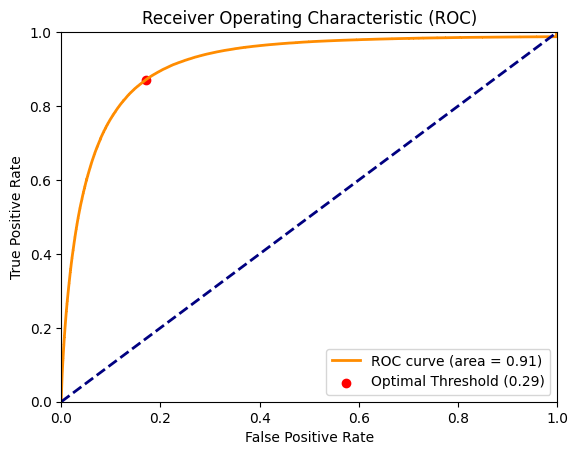

AUC : 0.9145561259345316
Optimal Threshold: 0.29


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

prob_matrix = df_score
adj_matrix = df_matrix

#결측치 제거
print("결측치 개수 : ",prob_matrix.isna().sum().sum())
prob_matrix = prob_matrix.fillna(0)

#y_true, y_score 변환
y_true = adj_matrix.values.flatten()
y_score = prob_matrix.values.flatten()
print(len(y_true), len(y_score))

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], c='red', marker='o', label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.savefig(f'./model output/{model_name}/{model_name} - ROC curve.png')

plt.show()

print(f'AUC : {roc_auc}')

print(f'Optimal Threshold: {optimal_threshold:.2f}')


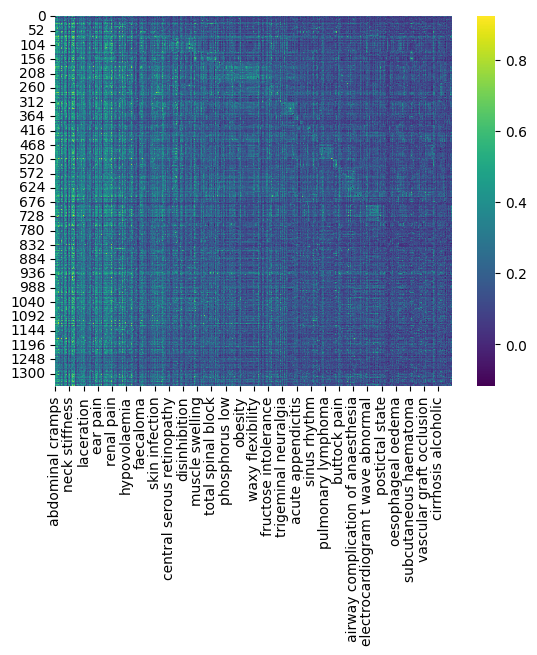

In [14]:
import seaborn as sns

sns.heatmap(df_score, cmap='viridis')
plt.savefig(f'./model output/{model_name}/{model_name} - Score heatmap.png')

## 연구 결과 데이터프레임

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

directory = './model output'  # Replace with the path to your directory

folder_names = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

print(folder_names)

['biobert-pubmed']


[biobert-pubmed]
AUC : 0.9009437720034922
Sensitivity : 0.8381932496710859
Specificity : 0.8283270022466558
Optimal Threshold: 0.82
[BiomedBERT]


FileNotFoundError: [Errno 2] No such file or directory: './model output/BiomedBERT/Relation score matrix.csv'

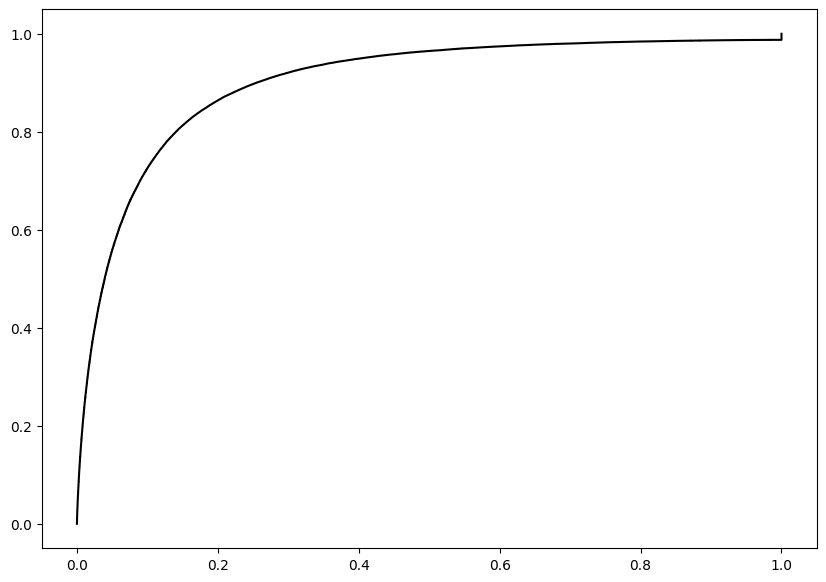

In [16]:
df_output = pd.DataFrame(columns=['AUC', 'Optimal Threshold', 'sensitivity', 'specificity'])
df_matrix = pd.read_csv('drug-SE adjacency matrix.csv')
df_matrix = df_matrix.drop("Unnamed: 0", axis=1)

folder_names = ['biobert-pubmed','BiomedBERT', 'biobert','PharmBERT-unfiltered', 'bert-base-uncased']
model_names = ['clagator/biobert_v1.1', 'BiomedBERT', 'dmis-lab/biobert_v1.1', 'PharmBERT-uncased', 'bert-base-uncased']
line_colors = ['black', 'blue', 'green', 'purple', 'orange']
line_shapes = ['-', '--', ':', '-.', '-']

plt.figure(figsize=(10,7))

for folder, model_name, line_color, line_shape in zip(folder_names, model_names,  line_colors, line_shapes):
    print(f"[{folder}]")
    df_score = pd.read_csv('./model output/' + folder + '/Relation score matrix.csv', index_col=0, engine='python')

    prob_matrix = df_score
    adj_matrix = df_matrix

    #결측치 제거
    prob_matrix = prob_matrix.fillna(0)

    #y_true, y_score 변환
    y_true = adj_matrix.values.flatten()
    y_score = prob_matrix.values.flatten()

    # ROC 곡선 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    optimal_threshold = thresholds[np.argmax(tpr - fpr)]
    print(f'AUC : {roc_auc}')
    
    #민감도, 특이도 도출
    sensitivity = tpr
    sensitivity = sensitivity[np.argmax(tpr - fpr)]
    specificity = 1-fpr
    specificity = specificity[np.argmax(tpr - fpr)]
    print(f'Sensitivity : {sensitivity}')
    print(f'Specificity : {specificity}')

    print(f'Optimal Threshold: {optimal_threshold:.2f}')
    
    # 새로운 데이터프레임에 AUC, Optimal Threshold 추가
    new_row = pd.DataFrame([[roc_auc, optimal_threshold, sensitivity, specificity]], columns=['AUC', 'Optimal Threshold', 'sensitivity', 'specificity'])
    new_row.index = [folder]
    df_output = pd.concat([df_output, new_row])
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', color=line_color, linestyle=line_shape)
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

df_output.to_csv('Research Output Table.csv')
df_output

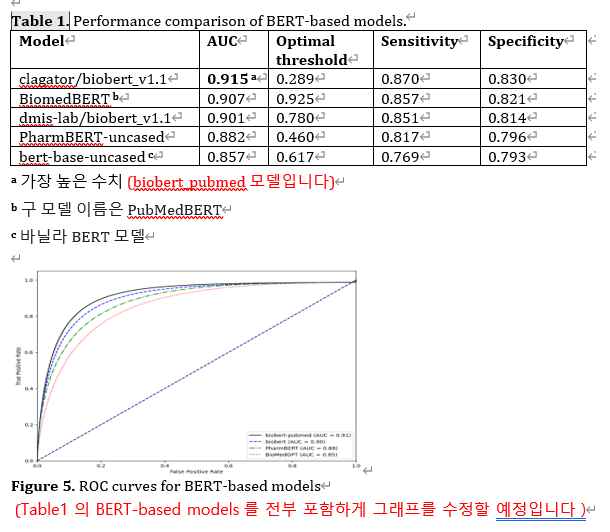